# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

This homework is primarily about running simulations involving initial value problems (IVPs) and a simple PDE.

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.integrate import DenseOutput
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.sparse as sparse
from sympy import Function, dsolve, Eq, Derivative, sin, cos, symbols
from scipy.integrate import solve_ivp
import importlib

## Problem 0 (30 points)

In this problem, you will implement a custom ODE solver for `solve_ivp` based on the Forward Euler method, and implement some basic tests.

### Part A (20 points)
If you read the [documentation for `solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), which we used in class, you'll see that you can write your own solver.

Write a solver for the forward Euler method, which is not implemented as one of the available solvers (while simple, it typically is not very accurate).  Recall, this is the basic rule:
\begin{equation}
y(t + h) = y(t) + h f(t, y)
\end{equation}

Your solver should be a class which is derived from [`scipy.integrate.OdeSolver`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.OdeSolver.html#scipy.integrate.OdeSolver)
```python
class ForwardEuler(scipy.integrate.OdeSolver):
    pass
```

Your class definition should go in [`euler.py`](euler.py)

You should read the documentation for this base class in order to implement `ForwardEuler`.  Here are some hints/notes:
* Allow a user to set `h` using a keyword argument.  This can be passed using `solve_ivp(..., method=ForwardEuler, h=0.01)` to set `h=0.01`
* Use a default step size `h = (t_bound - t0) / 100`
* private methods begin with an underscore "_"
* the method `_dense_output_impl(self)` should output a `ForwardEulerOutput` (defined in [`euler.py`](euler.py))
* direction should be `+1`
* You won't use a Jacobian, so `njev` and `nlu` can remain at 0.
* You may want to consider using `super(ForwardEuler, self).__init__`
* You may want to read the source code for the parent class [here](https://github.com/scipy/scipy/blob/v1.5.3/scipy/integrate/_ivp/base.py#L25-L214)

---

*put any discussion here*

In [2]:
from euler import ForwardEuler
from sympy.abc import x # x is overwritten in previous cells so we need to import here

### Part B (10 points)

Use your `ForwardEuler` solver and `solve_ivp` to solve an IVP $y'(t) = y$ with $y(0) = 1$ on the domain $t\in [0,5]$, using a step size `h=0.01`.  Make a plot of the solution to this IVP with axes labeled `y` and `x`.

Use SymPy to obtain the ground-truth solution to this IVP.  What is the largest error you see on the domain you solved the problem?  Try solving with the default solver in `solve_ivp`.  What is the largest error in this case?

---

*put your answers here*

SymPy ground-truth solution： Eq(y(x), exp(x))
ForwardEuler (h=0.01) maximum error: 3.640387e+00
default solver RK45 maximum error: 5.870946e-02


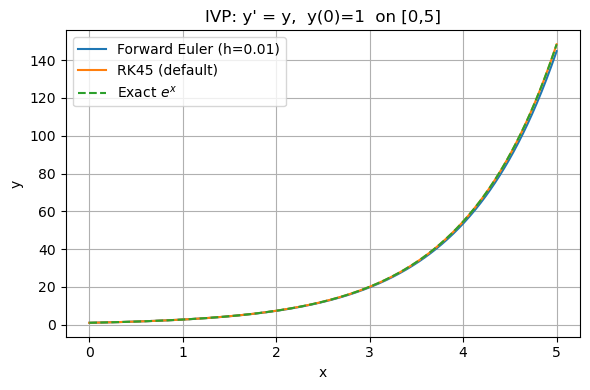

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp

# Define the ODE
def f(t, y):
    return y

t0, t1 = 0.0, 5.0
h = 0.01
t_eval = np.arange(t0, t1 + 1e-12, h)
y0 = [1.0]

# Solve with custom ForwardEuler
sol_fe = solve_ivp(f, (t0, t1), y0, method=ForwardEuler, h=h, t_eval=t_eval)
t = sol_fe.t
y_fe = sol_fe.y[0]

# Use SymPy to obtain the exact solution
y = sp.Function('y')
ode = sp.Eq(sp.diff(y(x), x), y(x))
sol_sym = sp.dsolve(ode, ics={y(0): 1})
print("SymPy ground-truth solution：", sol_sym)  
y_true_fn = sp.lambdify(x, sp.exp(x), 'numpy')
y_true = y_true_fn(t)

# Use the default solver (RK45) on the same grid
sol_def = solve_ivp(f, (t0, t1), y0, t_eval=t_eval)
y_def = sol_def.y[0]

# Compute the maximum error
max_err_fe = np.max(np.abs(y_fe - y_true))
max_err_def = np.max(np.abs(y_def - y_true))
print(f"ForwardEuler (h={h}) maximum error: {max_err_fe:.6e}")
print(f"default solver RK45 maximum error: {max_err_def:.6e}")

# Plot (per the problem statement: y on vertical axis, x on horizontal axis)
plt.figure(figsize=(6,4))
plt.plot(t, y_fe, label=f"Forward Euler (h={h})")
plt.plot(t, y_def, label="RK45 (default)")
plt.plot(t, y_true, "--", label="Exact $e^x$")
plt.xlabel("x")
plt.ylabel("y")
plt.title("IVP: y' = y,  y(0)=1  on [0,5]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Part C (optional challenge)

Use Richardson (see Problem 0) on your Forward Euler solver. How does the error change? You can assume that $m=1$ and derive the formula analytically. What happens if you do Richardson twice?

## Problem 1 (20 points)

Now that you're warmed up, here are some more simulations.

### Part A (15 points)

In this problem, we'll simulate a planet and moon moving in a 2-dimensional plane.

Newton's law of gravity says that $F_g = Gm_1 m_2 / \|r\|^2$.  The direction of the force is in the direction of the vector $r$.  Let $x(t)$ dentote the position of the planet and $y(t)$ denote the position of the moon, and $r(t) = x(t) - y(t)$ Then
\begin{equation}
x''(t) = -F_g / m_1 \times r / \|r\|\\
y''(t) = F_g / m_2 \times r / \|r\|
\end{equation}
$x$ and $y$ are 2-vectors, so this is a system of 4-second order ODEs.  We can use the following trick to write this as 8 first order ODEs. Let $p(t)$ be the velocity of the planet and $q(t)$ be the velocity of the moon (note that they are vector valued!). So, $p(t) = x'(t)$, and $q(t) = y'(t)$.  Here are the terms for $x$:
\begin{equation}
p_1'(t) = -F_g / m_1 \times r_1(t) / \|r\|\\
p_2'(t) = -F_g / m_1 \times r_2(t) / \|r\|\\
x_1'(t) = p_1(t)\\
x_2'(t) = p_2(t)
\end{equation}
\begin{equation}
q_1'(t) = F_g / m_2 \times r_1(t) / \|r\|\\
q_2'(t) = F_g / m_2 \times r_2(t) / \|r\|\\
y_1'(t) = q_1(t)\\
y_2'(t) = q_2(t)
\end{equation}

We'll model the Earth and moon.  The [Gravitational constant](https://en.wikipedia.org/wiki/Gravitational_constant) has value `G=6.67 e-11` (we're dropping units, which are all SI).  The mass of the earth is `m1 = 5.972 e24`, and the mass of the moon is `m2=0.07346 e24`.  The distance from the moon to the earth is `r = 384.4 e6`.  This means the orbital speed of the moon around the earth is about `1.022 e3`.

Use `solve_ivp` to run a simulation of the moon orbiting the earth for `5 e6` seconds (about 2 months).  Use initial conditions $x(0) = 0, p(0) = 0$ for the earth, and $y(0) = (0, 384.4 \times 10^6)$ and $q(0) = (1.022 \times 10^3, 0)$

Plot $x_1(t), x_2(t)$ and $y_1(t), y_2(t)$ in the same plane with different colors (include a legend and title).

---

*Put any answers/discussion here*

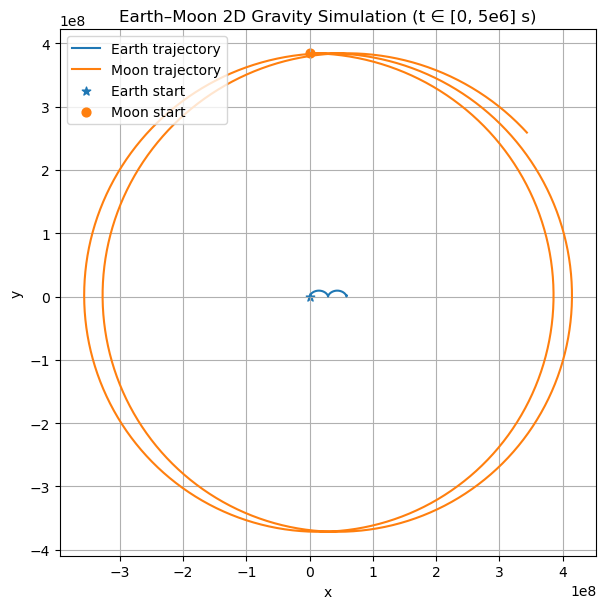

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

G  = 6.67e-11                 # gravitational constant
m1 = 5.972e24                 # Earth mass
m2 = 7.3476e22                # Moon mass
r0 = 384.4e6                  # Earth–Moon distance
v0 = 1.022e3                  # Moon orbital speed

x0 = np.array([0.0, 0.0])           # Earth initial position
p0 = np.array([0.0, 0.0])           # Earth initial velocity vector
y0 = np.array([0.0, r0])            # Moon initial position (on +y axis)
q0 = np.array([v0, 0.0])            # Moon initial velocity (along +x axis)

state0 = np.hstack([x0, p0, y0, q0])

# ODEs
def rhs(t, s):
    # Unpack
    x1, x2, p1, p2, y1, y2, q1, q2 = s
    x = np.array([x1, x2])
    p = np.array([p1, p2])   
    y = np.array([y1, y2])
    q = np.array([q1, q2])   

    r = x - y
    r_norm = np.linalg.norm(r)
    # Lower bound to avoid division by zero
    if r_norm < 1e-9:
        r_norm = 1e-9

    a_x = -(G * m2) * r / (r_norm**3)   # Earth acceleration
    a_y = +(G * m1) * r / (r_norm**3)   # Moon acceleration

    # First-order system
    dxdt = p          # x' = p
    dpdt = a_x        # p' = a_x
    dydt = q          # y' = q
    dqdt = a_y        # q' = a_y

    return np.hstack([dxdt, dpdt, dydt, dqdt])


t0, t1 = 0.0, 5.0e6                 # about two months
t_eval = np.linspace(t0, t1, 2000)
sol = solve_ivp(rhs, (t0, t1), state0, t_eval=t_eval,rtol=1e-10, atol=1e-10, method="RK45")
assert sol.success, f"Integration failed: {sol.message}"

# Extract trajectories and plot
x1_t = sol.y[0, :]   # Earth x-coordinate
x2_t = sol.y[1, :]   # Earth y-coordinate
y1_t = sol.y[4, :]   # Moon x-coordinate
y2_t = sol.y[5, :]   # Moon y-coordinate

plt.figure(figsize=(6.8, 6.2))
plt.plot(x1_t, x2_t, label="Earth trajectory")
plt.plot(y1_t, y2_t, label="Moon trajectory")
plt.scatter([x1_t[0]], [x2_t[0]], s=40, marker='*', label="Earth start")
plt.scatter([y1_t[0]], [y2_t[0]], s=40, marker='o', label="Moon start")

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Earth–Moon 2D Gravity Simulation (t ∈ [0, 5e6] s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Part B (5 points)

Now simulate a system with 10 planets, in 10 random locations. The planets should have random masses chosen independently and uniformly from the interval $[0,6 \times 10^{24}]$ and initial locations chosen randomly from the $(8 \times 10^8) \times (8\times 10^8)$ square centered at the origin. The components of each planet's initial velocity should be chosen randomly on $[-5\times 10^{2}, 5 \times 10^{2}].$ Plot the positions of each planet as a function of time.

---

*Your answer here.  You can create some code cells as well*

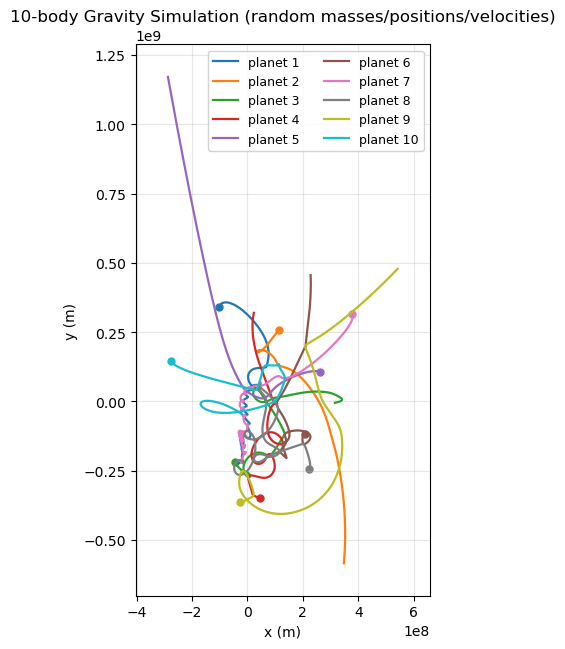

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Random seed
rng = np.random.default_rng(42)

G = 6.67e-11        # gravitational constant (SI)
N = 10              # number of planets

# Random initialization 
m = rng.uniform(0.0, 6.0e24, size=N)                       
pos0 = rng.uniform(-4.0e8, 4.0e8, size=(N, 2))            
vel0 = rng.uniform(-5.0e2, 5.0e2, size=(N, 2))            

y0 = np.hstack([pos0, vel0]).reshape(-1)

def rhs(t, y, masses):
    s = y.reshape(N, 4)
    r = s[:, :2]          # positions
    v = s[:, 2:]          # velocities

    dr = r[None, :, :] - r[:, None, :]
    eps2 = (1.0e6)**2
    dist2 = np.sum(dr**2, axis=2) + eps2                    
    inv_r3 = dist2**(-1.5)                                   
    np.fill_diagonal(inv_r3, 0.0)

    # a_i = G * Σ_{j≠i} m_j * (r_j - r_i) / |r_j - r_i|^3
    a = G * np.sum((dr * inv_r3[:, :, None]) * masses[None, :, None], axis=1)  # (N,2)

    dsdt = np.hstack([v, a]).reshape(-1)
    return dsdt


t0, t1 = 0.0, 5.0e5                 # total simulation time (seconds)
t_eval = np.linspace(t0, t1, 1500)  # number of output time samples
sol = solve_ivp(rhs, (t0, t1), y0, t_eval=t_eval, rtol=1e-8, atol=1e-10, args=(m,))
assert sol.success, sol.message

# Extract trajectories and plot
S = sol.y.T.reshape(-1, N, 4)       # shape: (T, N, 4)
R = S[:, :, :2]                     # positions (T, N, 2)

plt.figure(figsize=(7.2, 6.6))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

pad = 0.1 * (np.abs(R).max())
ax.set_xlim(R[:, :, 0].min() - pad, R[:, :, 0].max() + pad)
ax.set_ylim(R[:, :, 1].min() - pad, R[:, :, 1].max() + pad)

colors = plt.cm.tab10(np.linspace(0, 1, N))
for i in range(N):
    ax.plot(R[:, i, 0], R[:, i, 1], color=colors[i], lw=1.6, label=f"planet {i+1}")
    ax.scatter(R[0, i, 0], R[0, i, 1], s=25, color=colors[i], marker='o')  # mark initial position

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("10-body Gravity Simulation (random masses/positions/velocities)")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9, framealpha=0.85)
plt.tight_layout()
plt.show()

## Problem 2 (30 points)
In this problem, we will solve some a simple PDE using the "method of lines". In this method, we replace the
$$\partial_t u(t,x) = \Delta u(t,x) $$
PDE by the system of ODEs
$$ \partial_t\boldsymbol{u}(t) = A \boldsymbol{u}(t),$$
where
$$[\boldsymbol{u}(t)]_i=u_i(t) \approx u(t,x_i). $$
The matrix $A$ approximates the differential operator using, e.g. finite differences
$$ \Delta u \to A \boldsymbol{u}.$$

After we semi-discretize in space we are left with a large system of ODEs that we can solve using our favorite method.
 

### Part A (25 points)
In this problem we will solve the heat equation 
\begin{equation}
\begin{cases}
\partial_t u(t,x) = \Delta u(t,x) & x\in [0,1], \;t\in[0,T]\\
u(0,x) = f(x) & x\in [0,1]\\
u(t,0) = a & t \in [0,T]\\
u(t,1) = b & t \in [0,T]\\
\end{cases}
\end{equation}
with the method of lines.

To solve this equation, we discretize the interval $x\in[0,1]$ with $n+2$ points. The end points will be used to enforce boundary conditions and the interior points will be used to compute the right hand side of the PDE. We approximate the Laplacian operator using the second order centered difference formula
$$g''(x) = \frac{g(x+h)-2g(x)+g(x-h)}{h^2}$$
and we integrate in time using the forward Euler method.

Your code for implementing this method should include the following three functions
1. `second_diff`, which computes the second derivative of $u$ at the interior nodes (using the centered difference formula) and returns it as an array with zeros on each end (as the boundary conditions don't change)
2. `forward_time_step`, which uses $u(t_n,x)$ and the forward Euler method to compute $u(t_{n+1},x)$
3. `sim_heat`, which solves the heat equation by setting $u(0,x)=f(x)$ and then calling `forward_time_step` repeatedly to compute $u(T,x)$. This function should accept the following inputes
    * `n` the number of internal nodes 
    * `f` the initial condition
    * `bc` a list containing the left and right boundary conditions $a$ and $b$
    * `dx` the grid spacing, i.e. the distance between x values i.e. $1/(n+1)$
    * `dt` the time step to be used by the forward Euler method
    * `T` the time at which we want the solution $u(T,x)$. Note that in general $T/dt$ will not be an integer, so the last call of `forward_time_step` will have to use a smaller time step than `dt`

Once you have created these functions, solve the heat equation with
\begin{gather}
f(x) = \sin(2\pi x)\\
a = b = 0
\end{gather}
up until time $T=0.02$ using $n=99$ and `dt=0.2*dx**2`. 

To verify the accuracy of your code, compare the output to the exact solution $u(t,x)= \exp(-4\pi^2t)\sin(2\pi x)$. You can do this by summing the sum of squares errors at your $x_i$'s and dividing by $\sqrt{n}$.

You should also include a plot of $u(0,x)$ and $u(T,x)$.

In [6]:
def second_diff(u, dx):
    """
    Second-order central difference (discrete Laplacian): 
    Returns a 1D array of the same length as u.
    Convention: u includes boundary points (length n+2), internal indices 1..n.
    Both boundary ends return 0 (since boundary values are fixed and do not change over time).
    """
    u = np.asarray(u, dtype=float)
    out = np.zeros_like(u)
    out[1:-1] = (u[2:] - 2.0*u[1:-1] + u[:-2]) / (dx*dx)
    # out[0] and out[-1] remain 0
    return out


def time_step(u, dx, dt):
    """
    One forward Euler step: u^{n+1} = u^n + dt * (u_xx)^n
    Requirement: u already includes boundary values (indices 0 and -1), and boundaries remain fixed.
    """
    u = np.asarray(u, dtype=float)
    du = second_diff(u, dx)
    u_new = u + dt * du
    # Keep boundary values fixed
    u_new[0]  = u[0]
    u_new[-1] = u[-1]
    return u_new


def sim_heat(n, f, bc, dx, dt, T):
    """
    Solve the heat equation using the method of lines + forward Euler method.
    Returns (x, u_T).

    Parameters:
      n   : number of internal nodes (total nodes = n+2, including both boundaries)
      f   : initial condition function f(x)
      bc  : [a, b], left/right boundary constant values
      dx  : spatial step size = 1/(n+1)
      dt  : time step (recommended to satisfy stability condition dt <= dx^2/2)
      T   : target time

    Returns:
      x   : node coordinates (length n+2)
      u   : temperature at time T (length n+2)
    """
    a, b = bc
    x = np.linspace(0.0, 1.0, n+2)

    # Initial condition (including boundaries)
    u = np.asarray(f(x), dtype=float)
    u[0]  = a
    u[-1] = b

    t = 0.0
    # Iterate until reaching T; use a smaller dt for the last step to align exactly with T
    while t < T - 1e-15:
        dt_step = min(dt, T - t)
        u = time_step(u, dx, dt_step)
        t += dt_step

    return x, u

[result] L2/sqrt(n) error at T = 0.02: 1.676069e-05


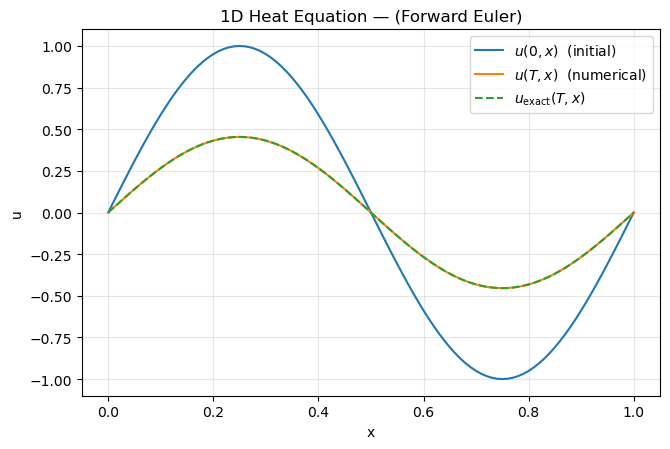

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Problem parameters
n  = 99
dx = 1.0 / (n + 1)           
dt = 0.2 * dx**2              # explicit Euler stable time step
T  = 0.02                     # target time
bc = [0.0, 0.0]               # boundary conditions a = b = 0

# Initial condition: f(x) = sin(2πx)
def f(x):
    return np.sin(2*np.pi*x)

# Save initial distribution and solve up to time T
x = np.linspace(0.0, 1.0, n+2)
u0 = f(x)
u0[0], u0[-1] = bc[0], bc[1]

x_T, uT = sim_heat(n=n, f=f, bc=bc, dx=dx, dt=dt, T=T)

# Exact solution: u(t,x) = exp(-4π^2 t) sin(2πx)
u_exact_T = np.exp(-4*np.pi**2 * T) * np.sin(2*np.pi * x_T)

# Compute error (per problem statement: L2 / sqrt(n) over interior nodes)
diff = uT[1:-1] - u_exact_T[1:-1]
l2_over_sqrtn = np.linalg.norm(diff) / np.sqrt(n)
print(f"[result] L2/sqrt(n) error at T = {T}: {l2_over_sqrtn:.6e}")

# Plot: u(0,x), u(T,x), and exact solution
plt.figure(figsize=(6.8, 4.6))
plt.plot(x, u0, label=r"$u(0,x)$  (initial)")
plt.plot(x_T, uT, label=r"$u(T,x)$  (numerical)")
plt.plot(x_T, u_exact_T, "--", label=r"$u_{\mathrm{exact}}(T,x)$")
plt.xlabel("x")
plt.ylabel("u")
plt.title("1D Heat Equation — (Forward Euler)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Part B (5 points)
Now solve for $u(T,x)$ using the same parameters as above, except that you should set `dt=0.7*dx**2`. Create a plot of $u(0,x)$ and $u(T,x)$ and compare it to the plot from the previous question. The ratio $dt/dx^2$ is called the CFL (Courant–Friedrichs–Lewy) number and the observation that you will make is an important concept in numerical PDE methods.

[result] L2/sqrt(n) error at T = 0.02: 1.871677e+56


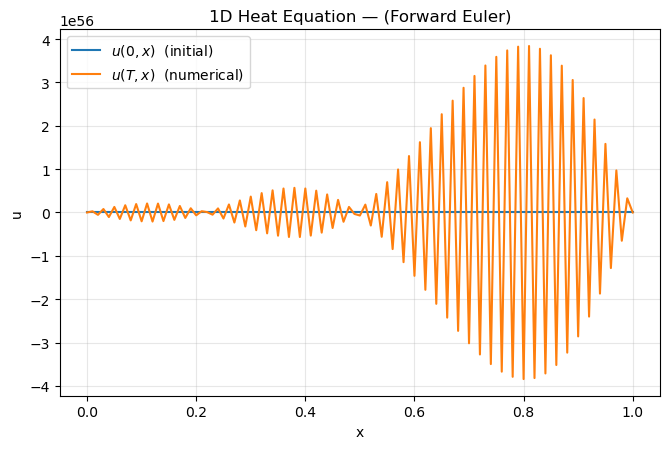

[info] dx = 1.00000e-02, dt = 7.00000e-05, CFL = 0.700 


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Problem parameters
n  = 99
dx = 1.0 / (n + 1)           
dt = 0.7 * dx**2              # explicit Euler stable time step
T  = 0.02                     # target time
bc = [0.0, 0.0]               # boundary conditions a = b = 0

# Initial condition: f(x) = sin(2πx)
def f(x):
    return np.sin(2*np.pi*x)

# Save initial distribution and solve up to time T
x = np.linspace(0.0, 1.0, n+2)
u0 = f(x)
u0[0], u0[-1] = bc[0], bc[1]

x_T, uT = sim_heat(n=n, f=f, bc=bc, dx=dx, dt=dt, T=T)

# Exact solution: u(t,x) = exp(-4π^2 t) sin(2πx)
u_exact_T = np.exp(-4*np.pi**2 * T) * np.sin(2*np.pi * x_T)

# Compute error (per problem statement: L2 / sqrt(n) over interior nodes)
diff = uT[1:-1] - u_exact_T[1:-1]
l2_over_sqrtn = np.linalg.norm(diff) / np.sqrt(n)
print(f"[result] L2/sqrt(n) error at T = {T}: {l2_over_sqrtn:.6e}")

# Plot: u(0,x), u(T,x)
plt.figure(figsize=(6.8, 4.6))
plt.plot(x, u0, label=r"$u(0,x)$  (initial)")
plt.plot(x_T, uT, label=r"$u(T,x)$  (numerical)")
plt.xlabel("x")
plt.ylabel("u")
plt.title("1D Heat Equation — (Forward Euler)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"[info] dx = {dx:.5e}, dt = {dt:.5e}, CFL = {dt/dx**2:.3f} ")

When the CFL (Courant–Friedrichs–Lewy) condition is not satisfied, the numerical solution becomes unstable, leading to rapidly growing oscillations and divergence from the true solution.

## Part C (optional, 5 bonus points)
The CFL condition that $dt/dx^2<0.5$ is prohibitively restrictive. To get around this, we can use so-called implicit time stepping schemes, which are far more stable, though computationally costly. The simplest of these schemes is the backwards Euler method:
$$ y(t_{n+1}) = y(t_n) + dt y'(t_{n+1})$$
(Note that $y'$ is now evaluated at a future time.) When solving a linear system of ODEs
$$ y'= A y$$
the backwards Euler method requires us to solve the linear system
$$ (I - dt A)y(t_{n+1}) = y(t_{n}). $$

In this problem you should modify your existing code to solve the heat equation using this implicit time stepping scheme. In order to do this efficiently, you should construct and store a Cholesky factorization of the matrix $I-dt A$.

With this new code, repeat the experiment from part B. Do you run into the same stability problem?

Further, with this method, are you able to make $dt$ a comparable size to $dx$?

[result] Backward Euler  L2/sqrt(n) error at T = 0.02: 4.350000e-04


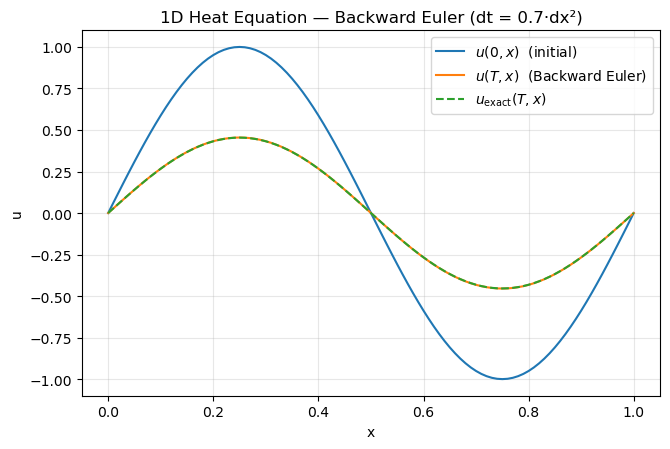

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve

def build_A_and_bvec(n, dx, a, b):
    """
    Construct the discrete Laplacian matrix A and boundary contribution vector bvec.
    
    Parameters
    ----------
    n : int
        Number of interior grid points (excluding the two boundaries)
    dx : float
        Grid spacing (distance between adjacent x points)
    a, b : float
        Boundary values at x=0 and x=1, respectively

    Returns
    -------
    A : ndarray, shape (n, n)
        Finite-difference Laplacian matrix with -2 on diagonal and +1 on off-diagonals
    bvec : ndarray, shape (n,)
        Boundary contribution vector due to fixed values a and b
    """
    main = (-2.0 / dx**2) * np.ones(n)
    off  = (1.0  / dx**2) * np.ones(n - 1)
    A = np.diag(main) + np.diag(off, 1) + np.diag(off, -1)
    bvec = np.zeros(n)
    if n >= 1:
        bvec[0]  += a / dx**2
        bvec[-1] += b / dx**2
    return A, bvec


def sim_heat_backward(n, f, bc, dx, dt, T):
    """
    Solve the 1D heat equation using the Backward Euler (implicit) method.
    
    (I - dt*A) * u^{k+1} = u^{k} + dt*bvec

    Parameters
    ----------
    n : int
        Number of interior nodes (total grid = n + 2)
    f : function
        Initial condition u(0,x)
    bc : list [a, b]
        Left and right boundary values
    dx : float
        Grid spacing
    dt : float
        Time step
    T : float
        Final time to simulate

    Returns
    -------
    x : ndarray, shape (n+2,)
        Full spatial grid (including boundaries)
    u_full : ndarray, shape (n+2,)
        Temperature at all points at time T
    """
    a, b = bc
    x = np.linspace(0.0, 1.0, n + 2)
    xi = x[1:-1]

    # Initial condition (include boundaries)
    u_full = f(x).astype(float)
    u_full[0], u_full[-1] = a, b
    u_int = u_full[1:-1].copy()

    # Build A and boundary term
    A, bvec = build_A_and_bvec(n, dx, a, b)

    # Compute Cholesky factorization of (I - dt*A)
    M = np.eye(n) - dt * A
    cF, lower = cho_factor(M, overwrite_a=False, check_finite=False)

    # Time integration loop
    t = 0.0
    while t < T - 1e-15:
        dt_step = min(dt, T - t)
        # If last time step is shorter, recompute Cholesky for that smaller dt
        if dt_step != dt:
            M_last = np.eye(n) - dt_step * A
            cF_last, lower_last = cho_factor(M_last, overwrite_a=False, check_finite=False)
            rhs = u_int + dt_step * bvec
            u_int = cho_solve((cF_last, lower_last), rhs, check_finite=False)
        else:
            rhs = u_int + dt * bvec
            u_int = cho_solve((cF, lower), rhs, check_finite=False)
        t += dt_step

    # Reconstruct full solution including boundaries
    u_full[1:-1] = u_int
    return x, u_full


# Main experiment

n  = 99
dx = 1.0 / (n + 1)
dt = 0.7 * dx**2       # large timestep (unstable for Forward Euler)
T  = 0.02
bc = [0.0, 0.0]

# Initial condition: f(x) = sin(2πx)
def f(x):
    return np.sin(2 * np.pi * x)

# Compute numerical solution
x, u_be = sim_heat_backward(n, f, bc, dx, dt, T)

# Analytical solution: u(t,x) = exp(-4π²t) sin(2πx)
u_exact = np.exp(-4 * np.pi**2 * T) * np.sin(2 * np.pi * x)

# Compute L2/sqrt(n) error over interior nodes
err = u_be[1:-1] - u_exact[1:-1]
l2_over_sqrtn = np.linalg.norm(err) / np.sqrt(n)
print(f"[result] Backward Euler  L2/sqrt(n) error at T = {T}: {l2_over_sqrtn:.6e}")


# Plot: compare u(0,x), u(T,x), and exact solution
u0 = f(x)
u0[0], u0[-1] = bc
plt.figure(figsize=(6.8, 4.6))
plt.plot(x, u0, label=r"$u(0,x)$  (initial)")
plt.plot(x, u_be, label=r"$u(T,x)$  (Backward Euler)")
plt.plot(x, u_exact, "--", label=r"$u_{\mathrm{exact}}(T,x)$")
plt.xlabel("x")
plt.ylabel("u")
plt.title("1D Heat Equation — Backward Euler (dt = 0.7·dx²)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Feedback

If you would like share how long it took you to complete this assignment, it will help adjust the difficulty for future assignments.  You're welcome to share additional feedback as well.